In [1]:
!pip install opencv-python numpy ultralytics torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/HABBOF.zip" -d "/content"



Streaming output truncated to the last 5000 lines.
  inflating: /content/HABBOF/Lab2/001549.jpg  
  inflating: /content/HABBOF/Lab2/001549.txt  
  inflating: /content/HABBOF/Lab2/001550.jpg  
  inflating: /content/HABBOF/Lab2/001550.txt  
  inflating: /content/HABBOF/Lab2/001551.jpg  
  inflating: /content/HABBOF/Lab2/001551.txt  
  inflating: /content/HABBOF/Lab2/001552.jpg  
  inflating: /content/HABBOF/Lab2/001552.txt  
  inflating: /content/HABBOF/Lab2/001553.jpg  
  inflating: /content/HABBOF/Lab2/001553.txt  
  inflating: /content/HABBOF/Lab2/001554.jpg  
  inflating: /content/HABBOF/Lab2/001554.txt  
  inflating: /content/HABBOF/Lab2/001555.jpg  
  inflating: /content/HABBOF/Lab2/001555.txt  
  inflating: /content/HABBOF/Lab2/001556.jpg  
  inflating: /content/HABBOF/Lab2/001556.txt  
  inflating: /content/HABBOF/Lab2/001557.jpg  
  inflating: /content/HABBOF/Lab2/001557.txt  
  inflating: /content/HABBOF/Lab2/001558.jpg  
  inflating: /content/HABBOF/Lab2/001558.txt  
  inflati

In [4]:
import os
from glob import glob
from PIL import Image
import numpy as np
import math

# Convert rotated bbox [cx, cy, w, h, angle] to axis-aligned [x_min, y_min, x_max, y_max]
def rotated_to_axis_aligned(cx, cy, w, h, angle_deg):
    angle = math.radians(angle_deg)
    dx = w / 2
    dy = h / 2
    corners = np.array([
        [-dx, -dy],
        [ dx, -dy],
        [ dx,  dy],
        [-dx,  dy]
    ])
    rotation_matrix = np.array([
        [math.cos(angle), -math.sin(angle)],
        [math.sin(angle),  math.cos(angle)]
    ])
    rotated_corners = corners @ rotation_matrix.T + np.array([cx, cy])
    x_min, y_min = np.min(rotated_corners, axis=0)
    x_max, y_max = np.max(rotated_corners, axis=0)
    return x_min, y_min, x_max, y_max

# Paths
folders = ["/content/HABBOF/Lab1", "/content/HABBOF/Lab2", "/content/HABBOF/Meeting1", "/content/HABBOF/Meeting2"]

for folder in folders:
    label_paths = glob(os.path.join(folder, "*.txt"))

    for label_path in label_paths:
        img_path = label_path.replace(".txt", ".jpg")
        if not os.path.exists(img_path):
            continue

        # Get image size
        with Image.open(img_path) as img:
            img_w, img_h = img.size

        new_lines = []
        with open(label_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue  # Invalid format
                class_name, x, y, w, h, angle = parts
                if class_name.lower() != "person":
                    continue  # Skip unknown classes

                # Convert to float
                x, y, w, h, angle = map(float, [x, y, w, h, angle])

                # Convert rotated box to axis-aligned
                x_min, y_min, x_max, y_max = rotated_to_axis_aligned(x, y, w, h, angle)

                # Clamp to image boundaries
                x_min = max(0, min(x_min, img_w))
                y_min = max(0, min(y_min, img_h))
                x_max = max(0, min(x_max, img_w))
                y_max = max(0, min(y_max, img_h))

                # Convert to YOLO format
                x_center = (x_min + x_max) / 2 / img_w
                y_center = (y_min + y_max) / 2 / img_h
                w_norm = (x_max - x_min) / img_w
                h_norm = (y_max - y_min) / img_h

                new_line = f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
                new_lines.append(new_line)

        # Overwrite with new labels
        with open(label_path, "w") as f:
            f.write("\n".join(new_lines))


In [5]:
import os
from glob import glob

# All label folders
label_folders = ["/content/lab1", "/content/lab2", "/content/meeting1", "/content/meeting2"]

def is_valid_yolo_line(line):
    parts = line.strip().split()
    if len(parts) != 5:
        return False
    try:
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))
        return all(0 <= val <= 1 for val in coords)
    except ValueError:
        return False

# Loop through all .txt files
invalid_labels = []

for folder in label_folders:
    label_files = glob(os.path.join(folder, "*.txt"))
    for label_file in label_files:
        with open(label_file, "r") as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                if not is_valid_yolo_line(line):
                    invalid_labels.append((label_file, i + 1, line.strip()))

# Report
if invalid_labels:
    print("❌ Found invalid labels:")
    for file, line_num, line in invalid_labels:
        print(f"{file} [line {line_num}]: {line}")
else:
    print("✅ All label files are correctly formatted.")


✅ All label files are correctly formatted.


In [6]:
import os
from glob import glob
from shutil import copy2
import random

# Input folders
data_dirs = ["/content/HABBOF/Lab1", "/content/HABBOF/Lab2", "/content/HABBOF/Meeting1", "/content/HABBOF/Meeting2"]

# Output folders
output_base = "/content/dataset"
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f"{output_base}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_base}/{split}/labels", exist_ok=True)

# Gather all image-label pairs
image_label_pairs = []
for d in data_dirs:
    images = glob(os.path.join(d, "*.jpg"))
    for img_path in images:
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(d, base_name + ".txt")
        if os.path.exists(label_path):
            image_label_pairs.append((img_path, label_path))
        else:
            print(f"⚠️ Missing label for: {img_path}")

# Shuffle and split
random.shuffle(image_label_pairs)
n = len(image_label_pairs)
train_split = int(0.7 * n)
val_split = int(0.9 * n)

split_map = {
    'train': image_label_pairs[:train_split],
    'val': image_label_pairs[train_split:val_split],
    'test': image_label_pairs[val_split:]
}

# Copy files to split folders
for split, pairs in split_map.items():
    for img, lbl in pairs:
        copy2(img, f"{output_base}/{split}/images/{os.path.basename(img)}")
        copy2(lbl, f"{output_base}/{split}/labels/{os.path.basename(lbl)}")


In [7]:
# Install necessary packages for YOLOv5
!pip install torch torchvision torchaudio
!pip install yolov5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 8.4 MB/s eta 0:00:00
  Creat

In [8]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 17485, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 17485 (delta 81), reused 31 (delta 31), pack-reused 17374 (from 3)
Receiving objects: 100% (17485/17485), 16.39 MiB | 19.88 MiB/s, done.
Resolving deltas: 100% (11986/11986), done.
/content/yolov5


In [9]:
yaml_content = """
train: /content/dataset/train
val: /content/dataset/val

nc: 1  # Number of classes (for person detection)
names: ['person']  # Class names
"""

# Write the YAML file for YOLOv5
yaml_path = "/content/yolov5/dataset.yaml"

with open(yaml_path, "w") as file:
    file.write(yaml_content)

print(f"Dataset YAML file created at {yaml_path}")


Dataset YAML file created at /content/yolov5/dataset.yaml


In [10]:
!python train.py --img 640 --batch 16 --epochs 15 --data /content/yolov5/dataset.yaml --weights yolov5s.pt --name yolov5_custom


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-05-20 10:41:02.967826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747737663.278984    2001 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747737663.363113    2001 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

In [11]:
from google.colab import files
files.download('runs/train/yolov5_custom/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
!python detect.py \
  --weights runs/train/yolov5_custom/weights/best.pt \
  --source /content/dataset/test/images \
  --conf 0.25 \
  --save-txt \
  --save-conf \
  --project runs/detect \
  --name test_results \
  --exist-ok


detect: weights=['runs/train/yolov5_custom/weights/best.pt'], source=/content/dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/512 /content/dataset/test/images/000006.jpg: 640x640 4 persons, 11.4ms
image 2/512 /content/dataset/test/images/000007.jpg: 640x640 3 persons, 11.5ms
image 3/512 /content/dataset/test/images/000011.jpg: 640x640 4 persons, 11.5ms
image 4/512 /content/dataset/test/images/000012.jpg:

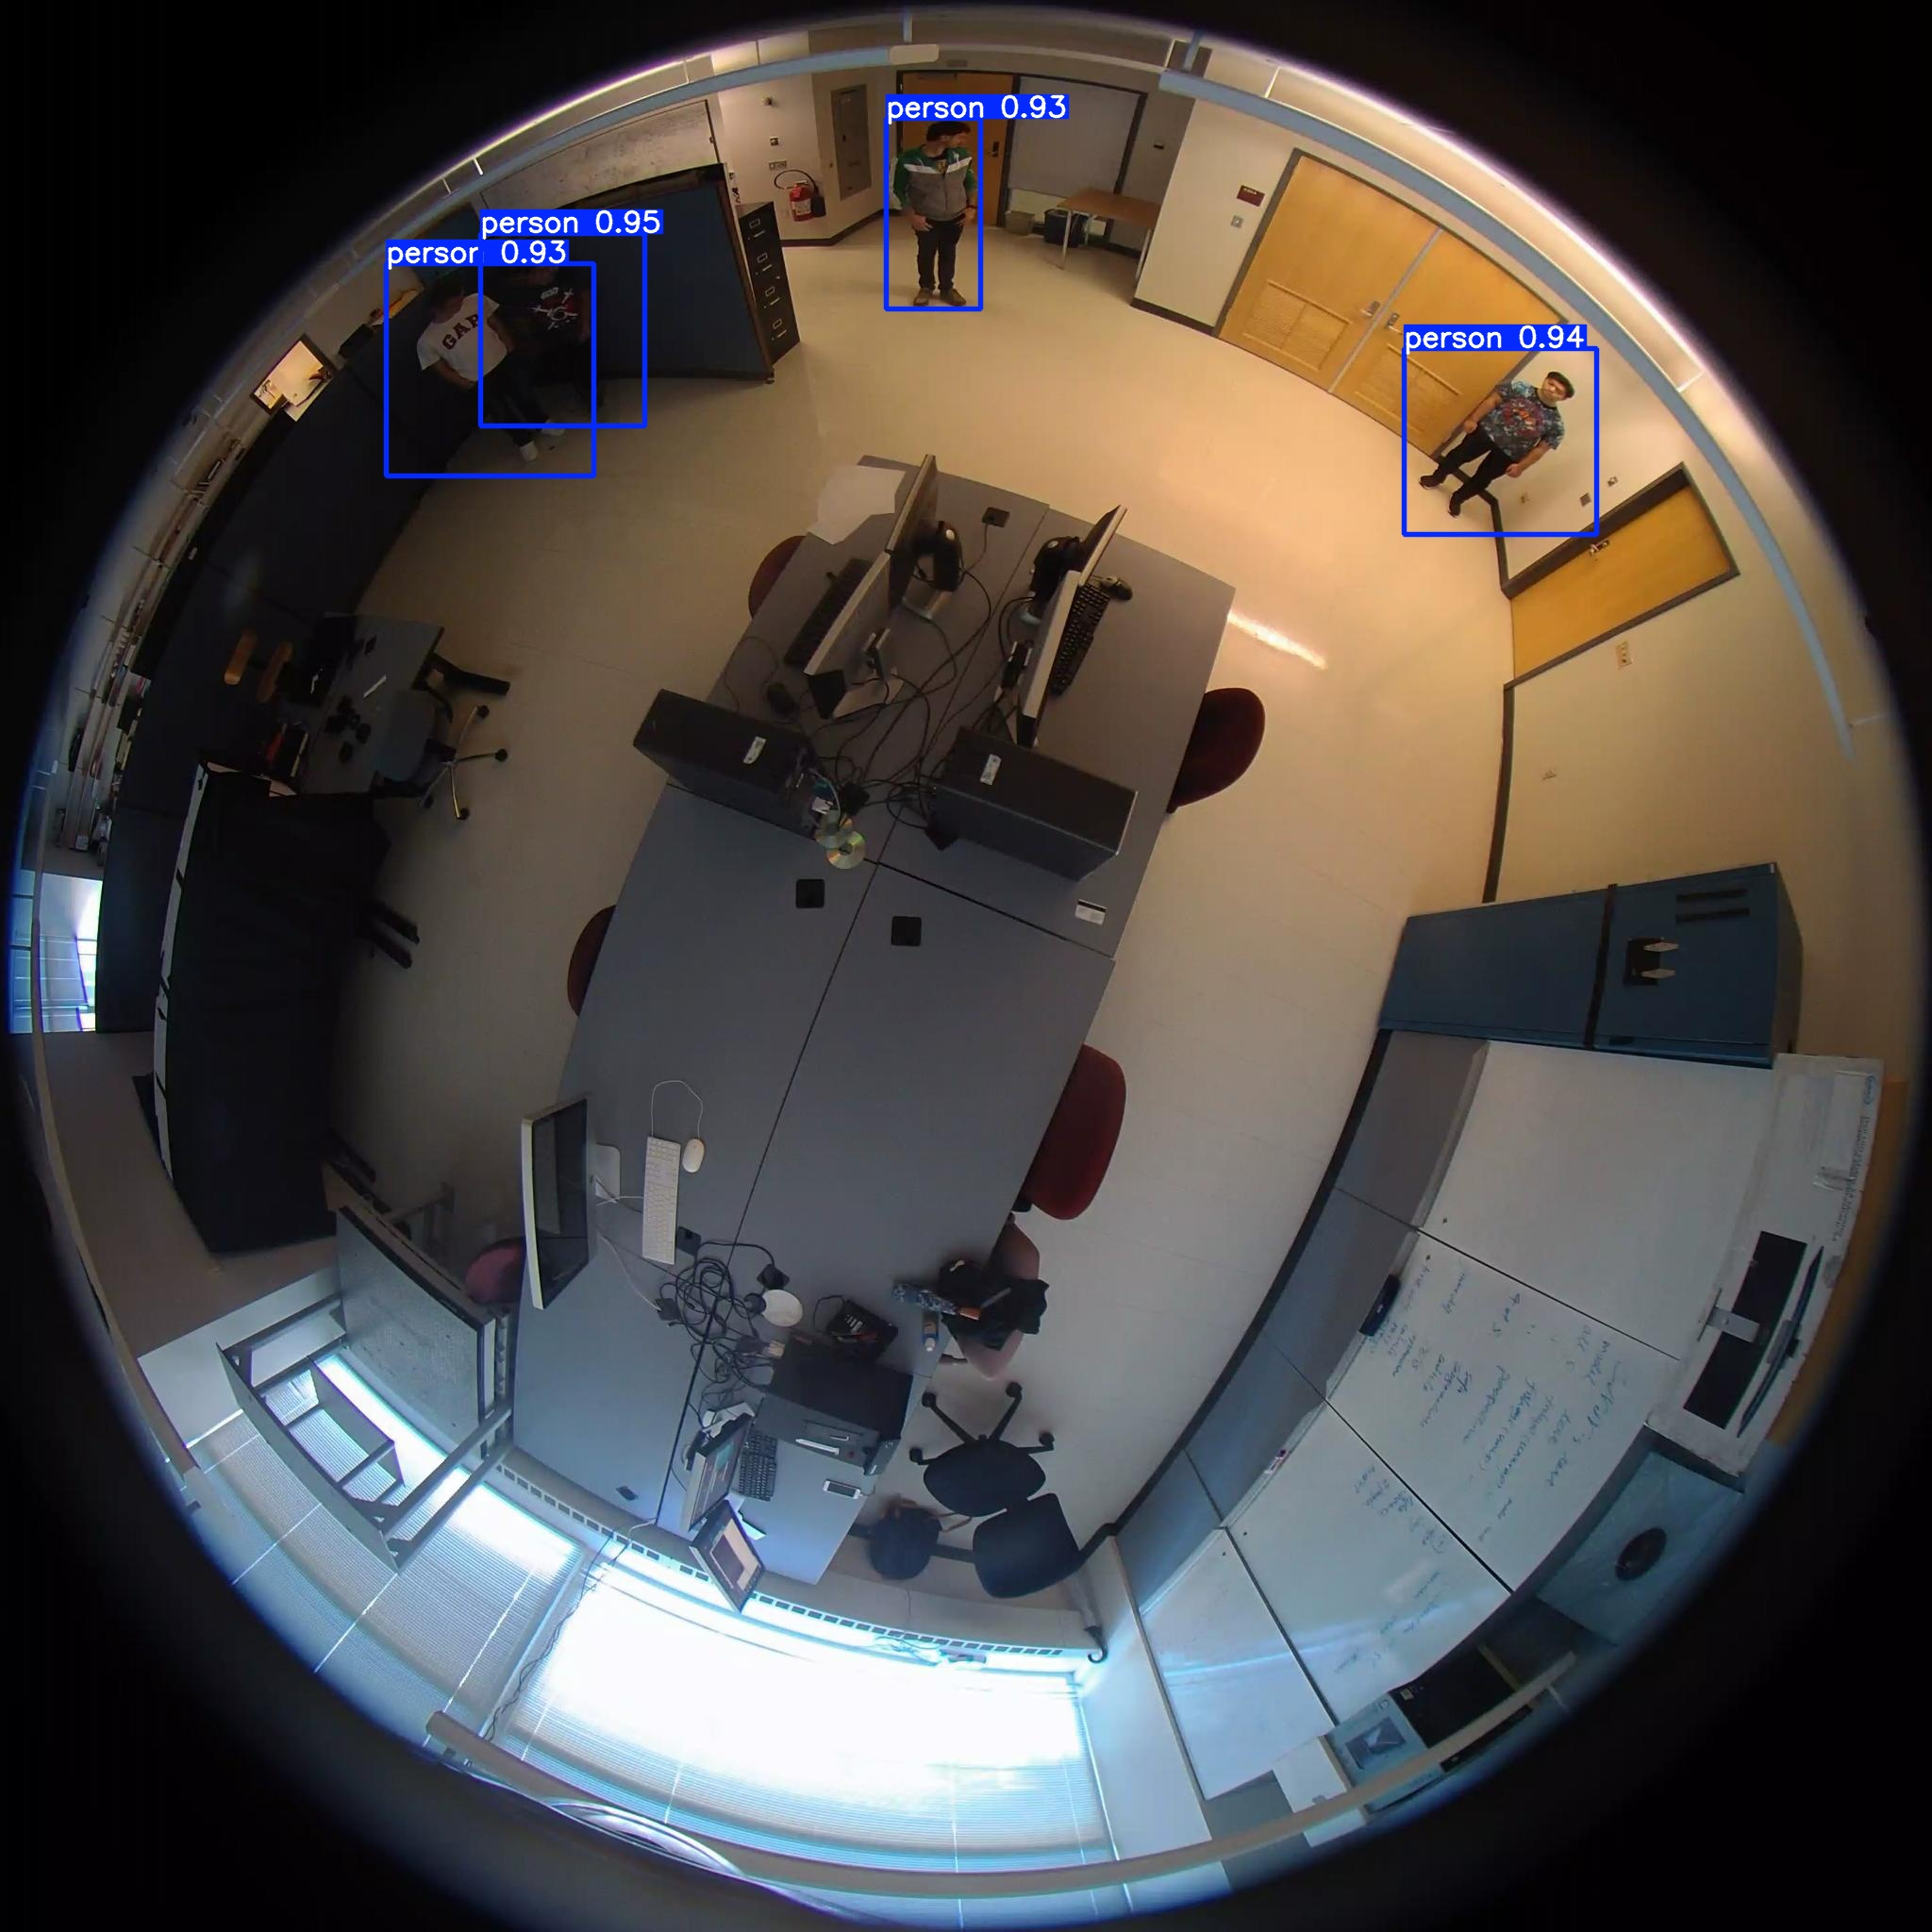

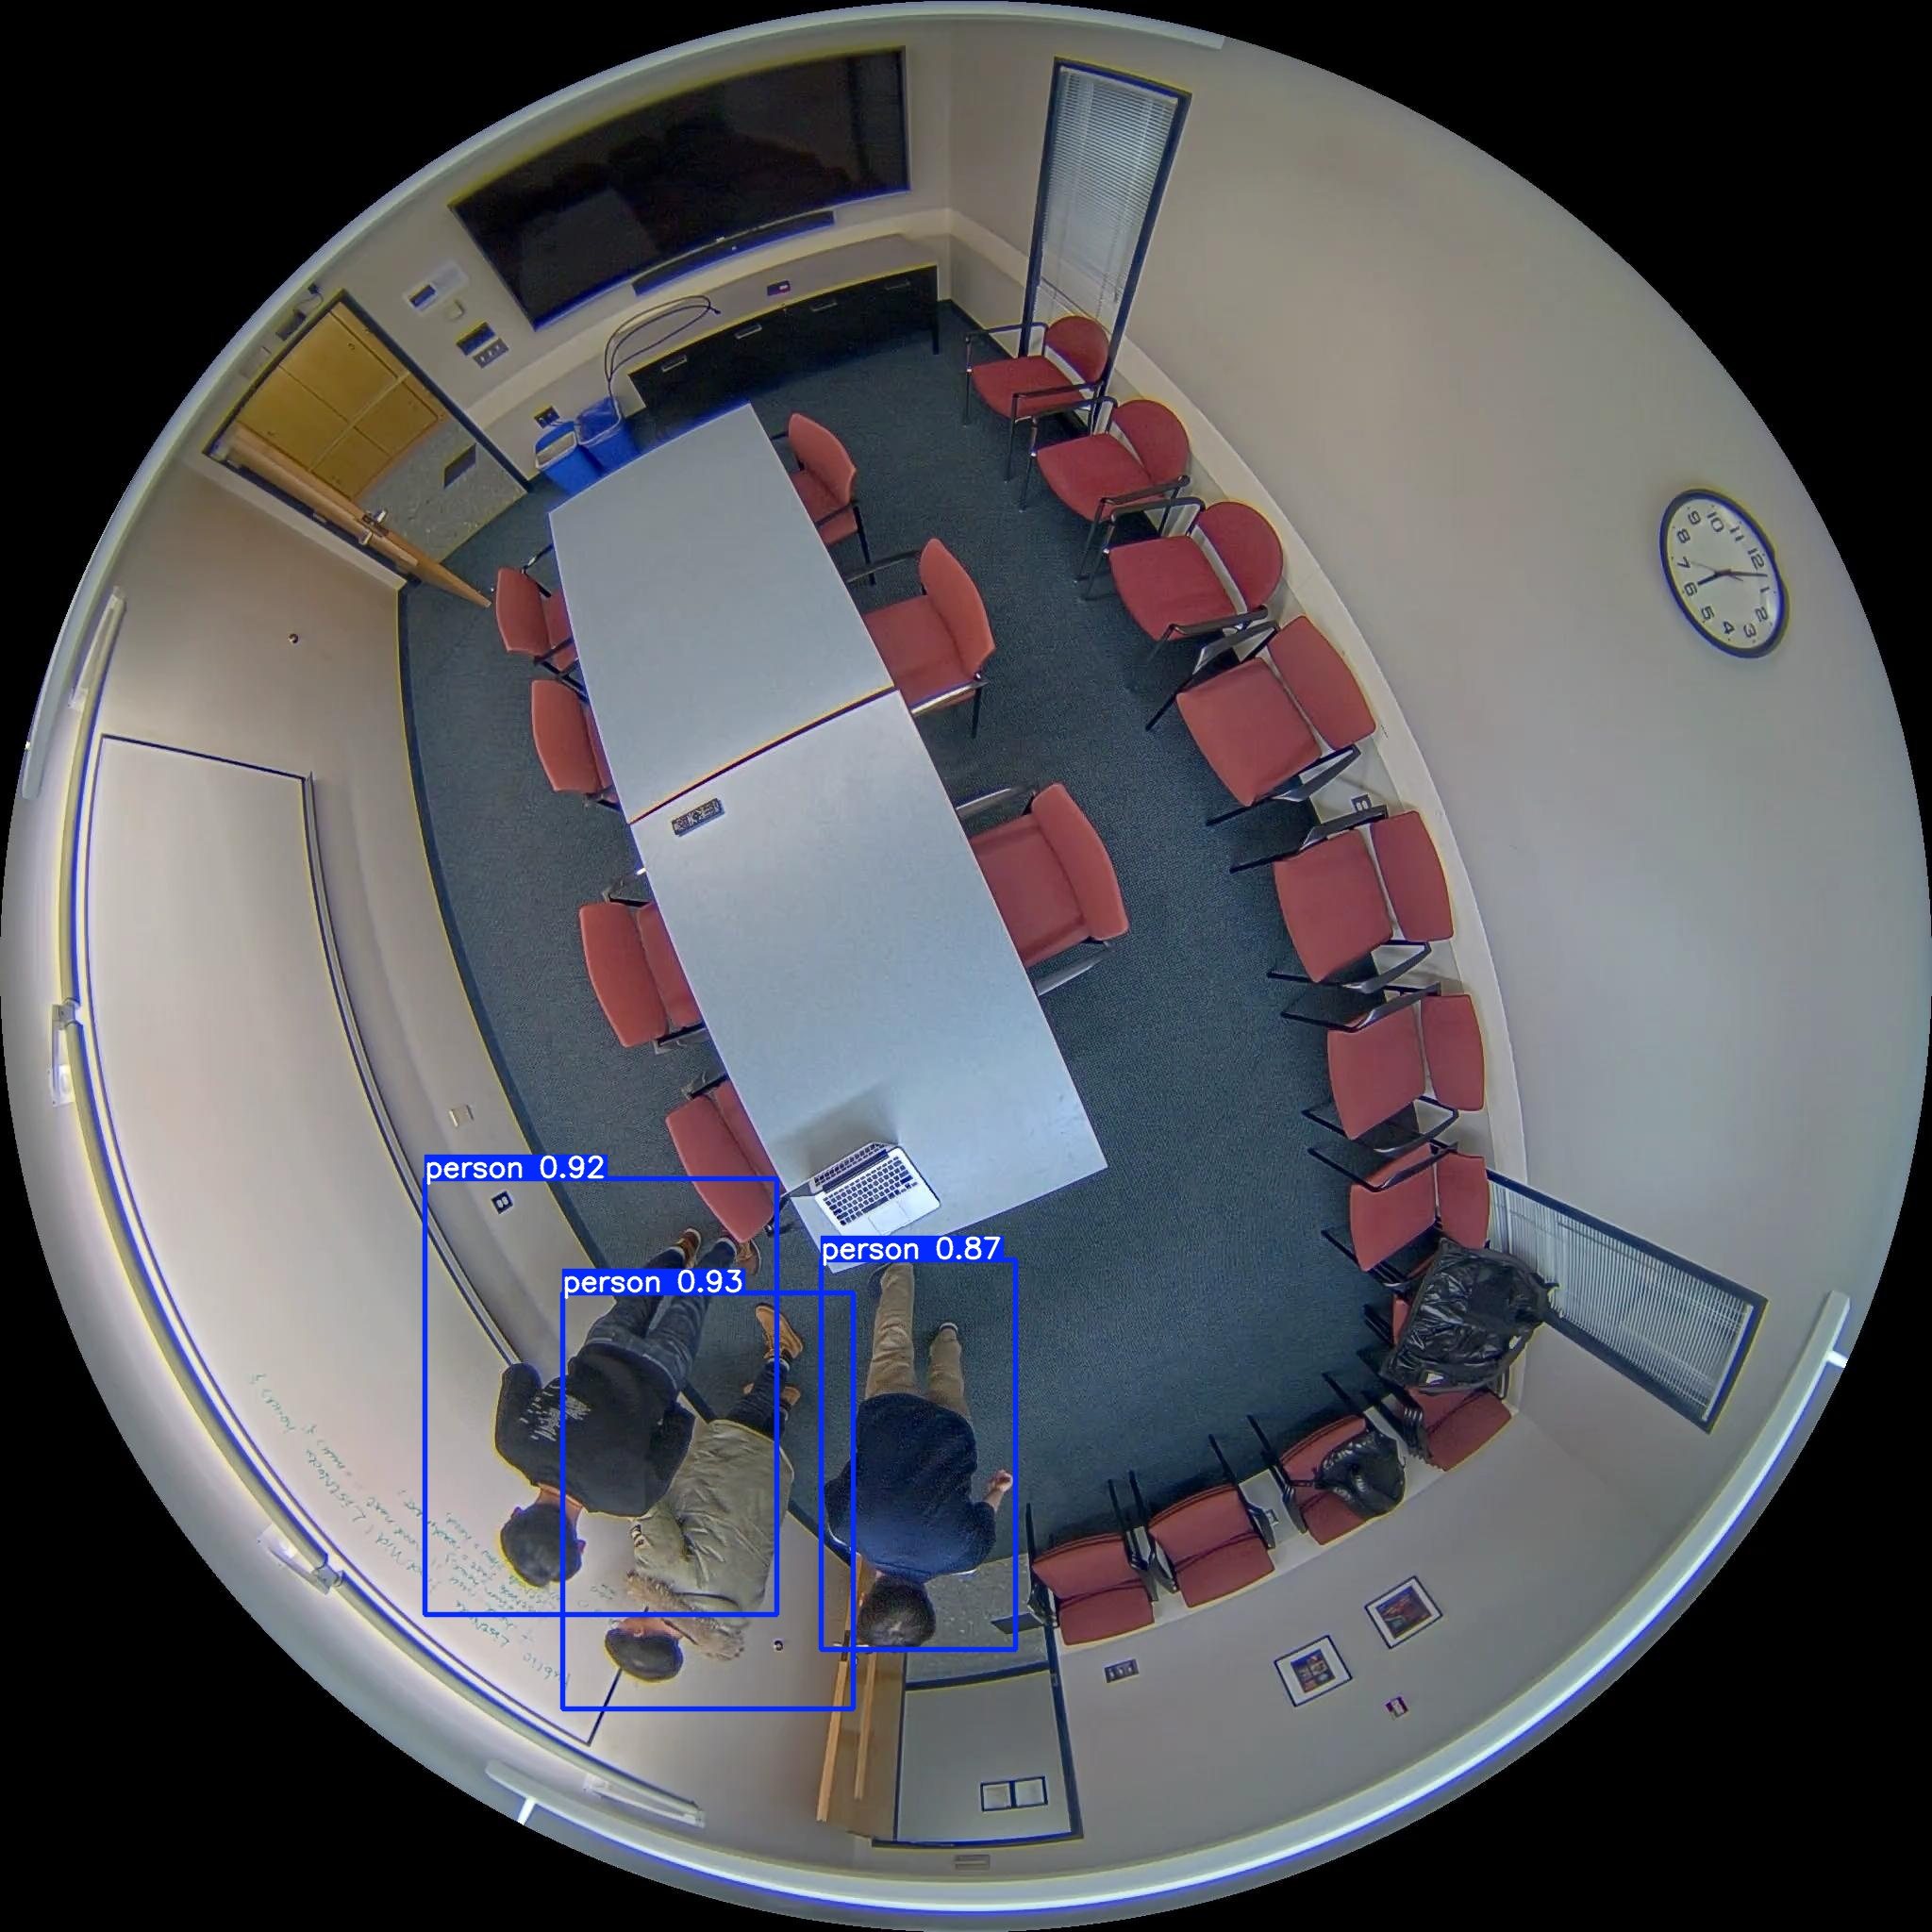

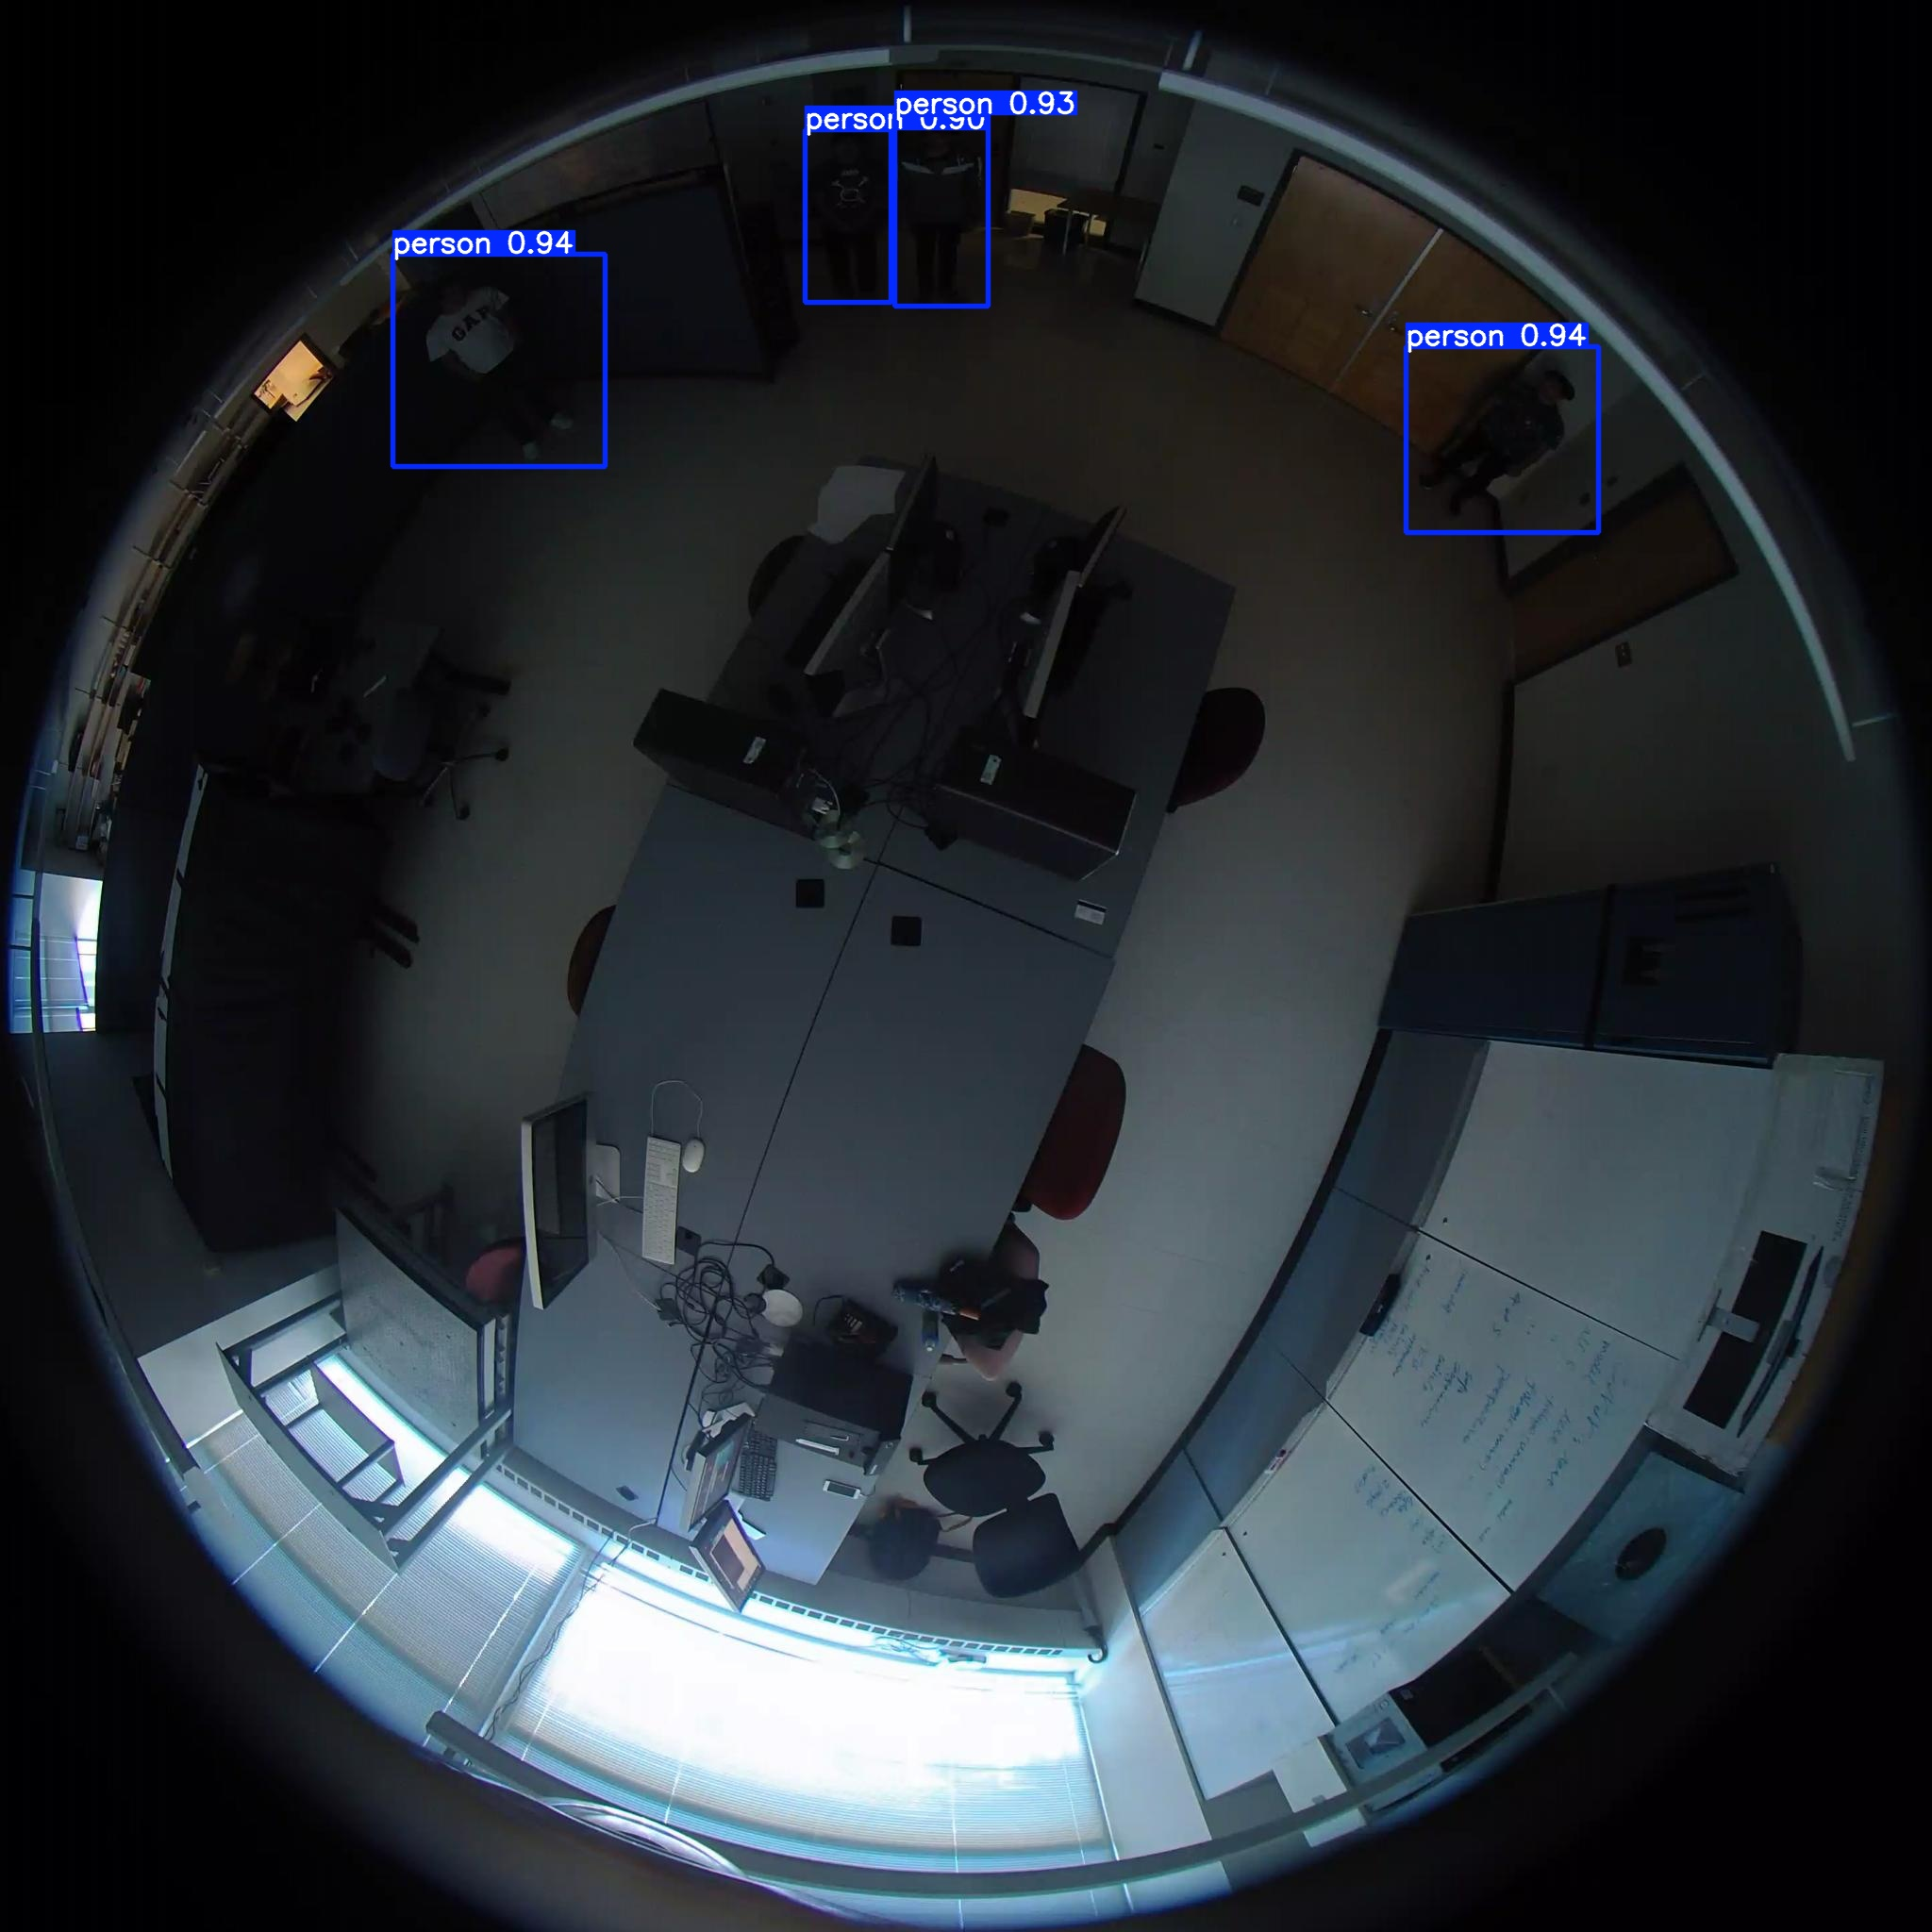

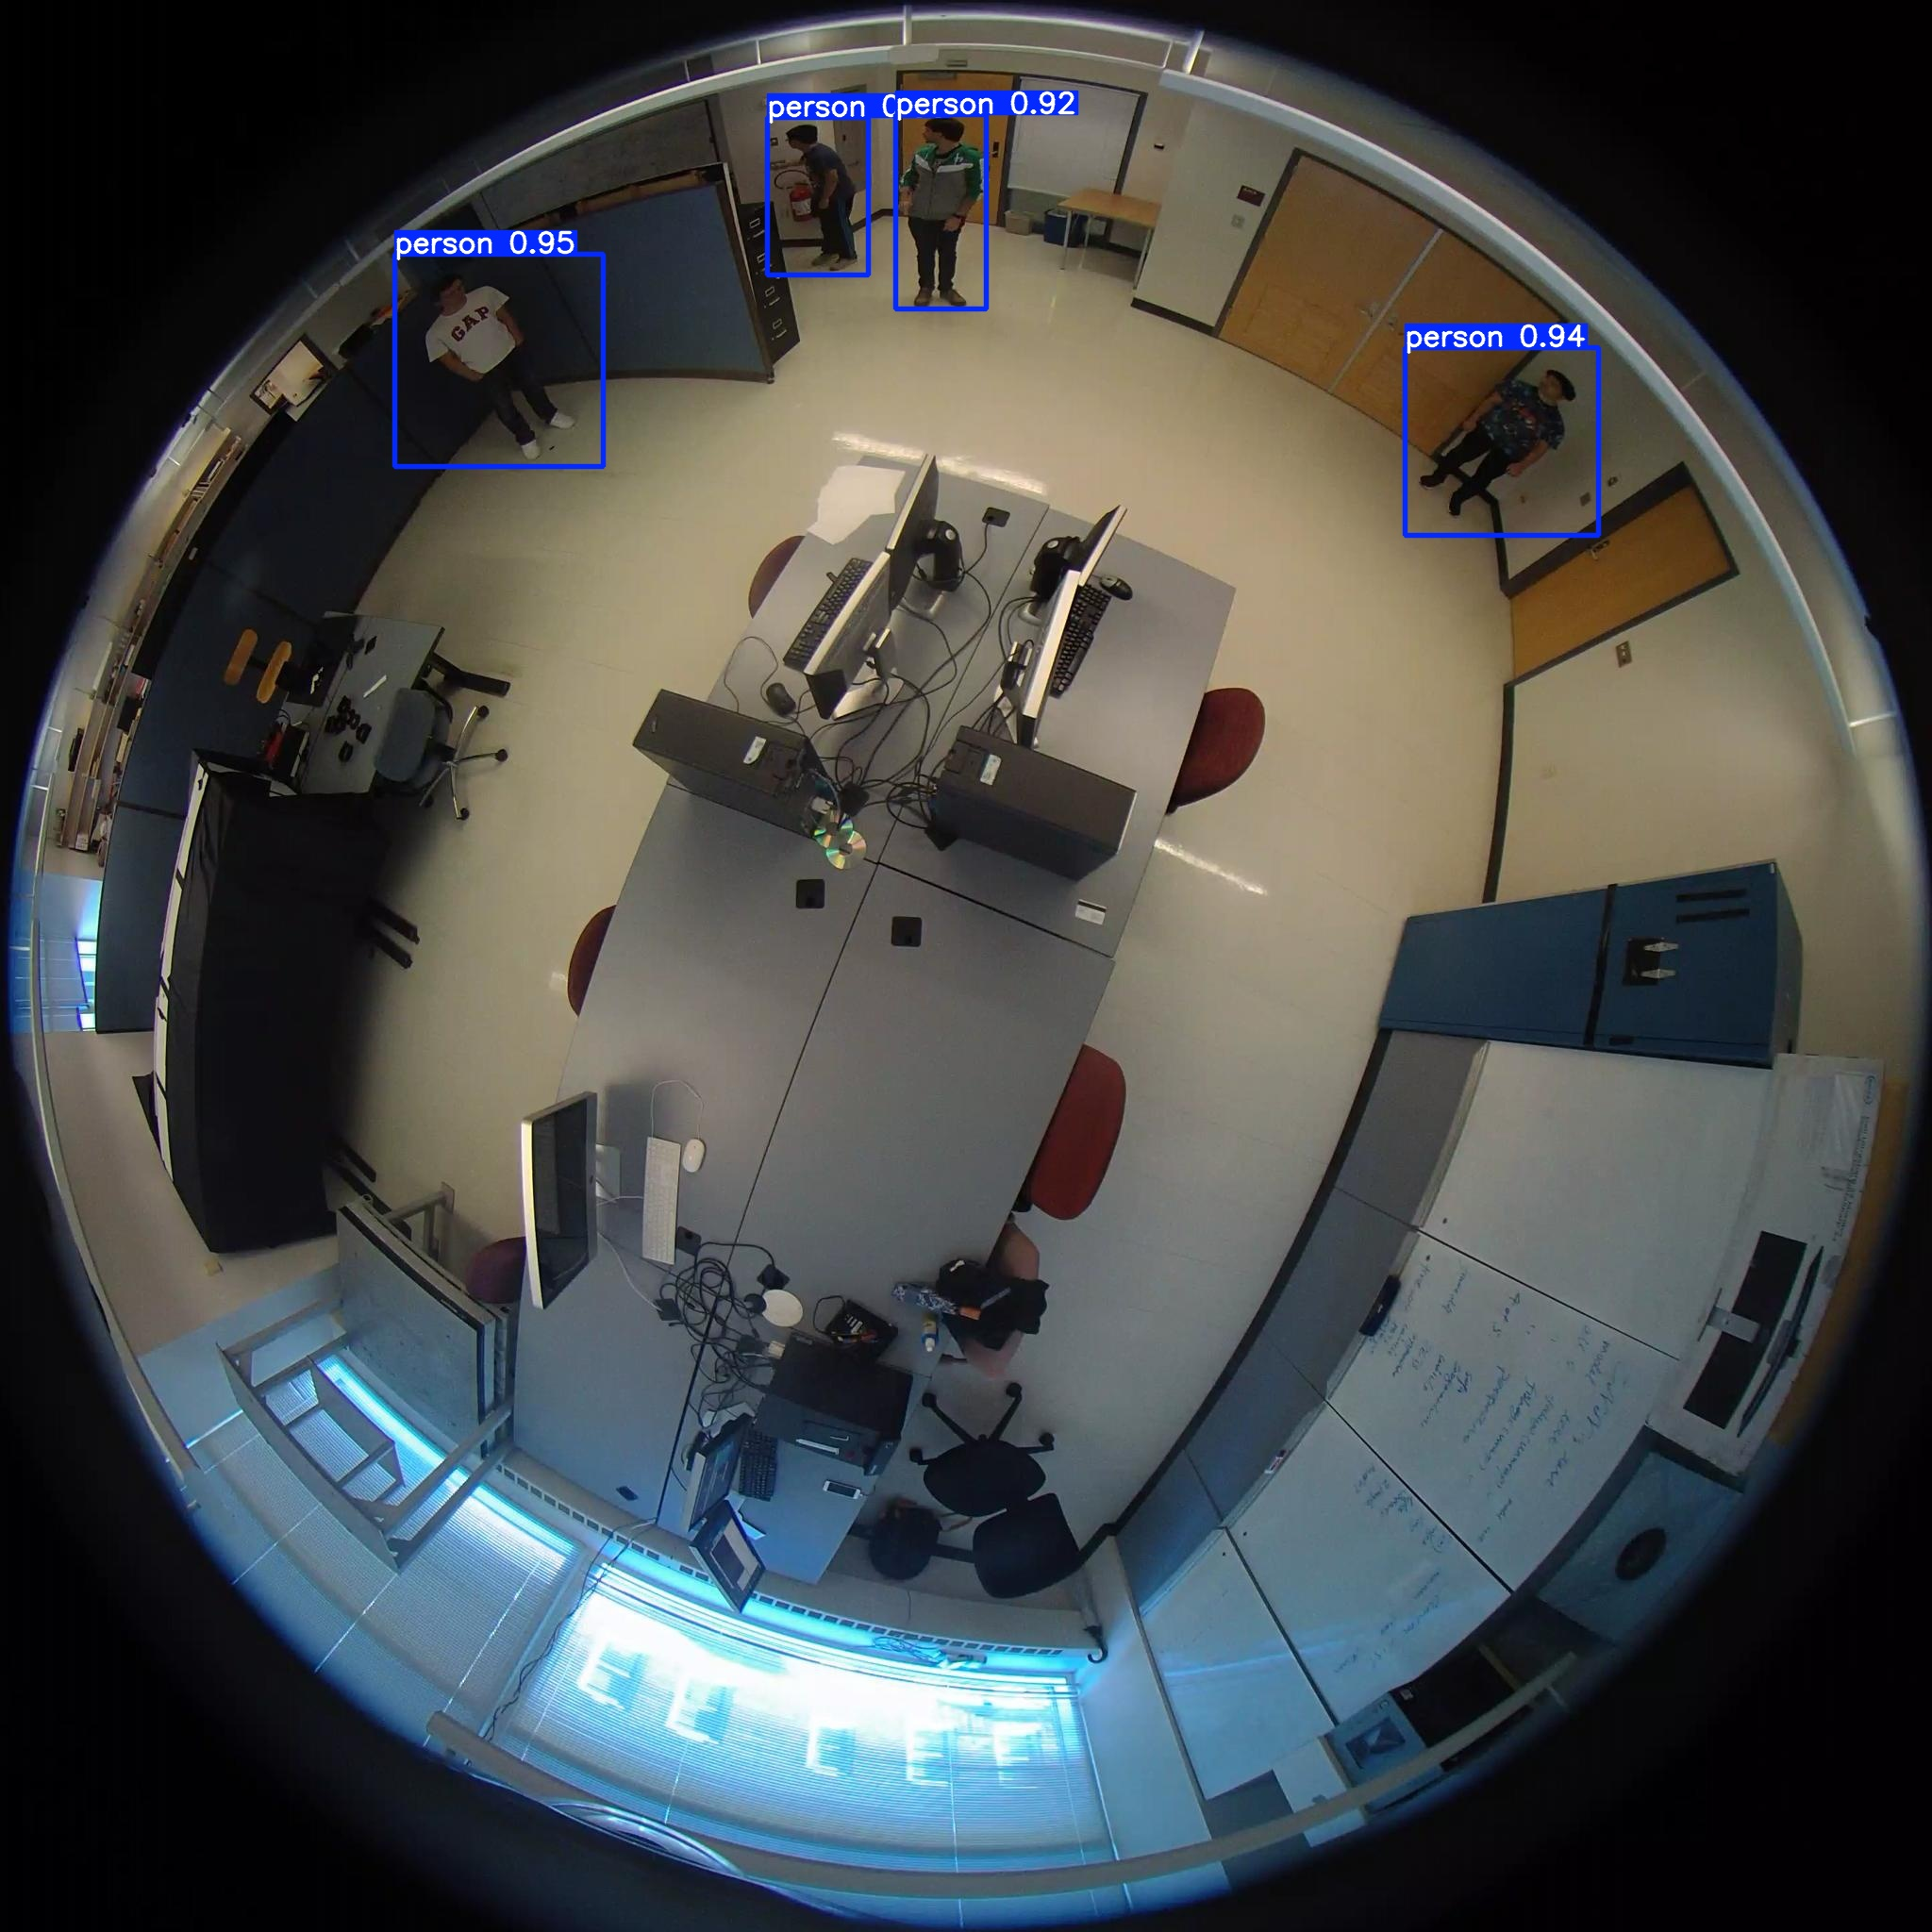

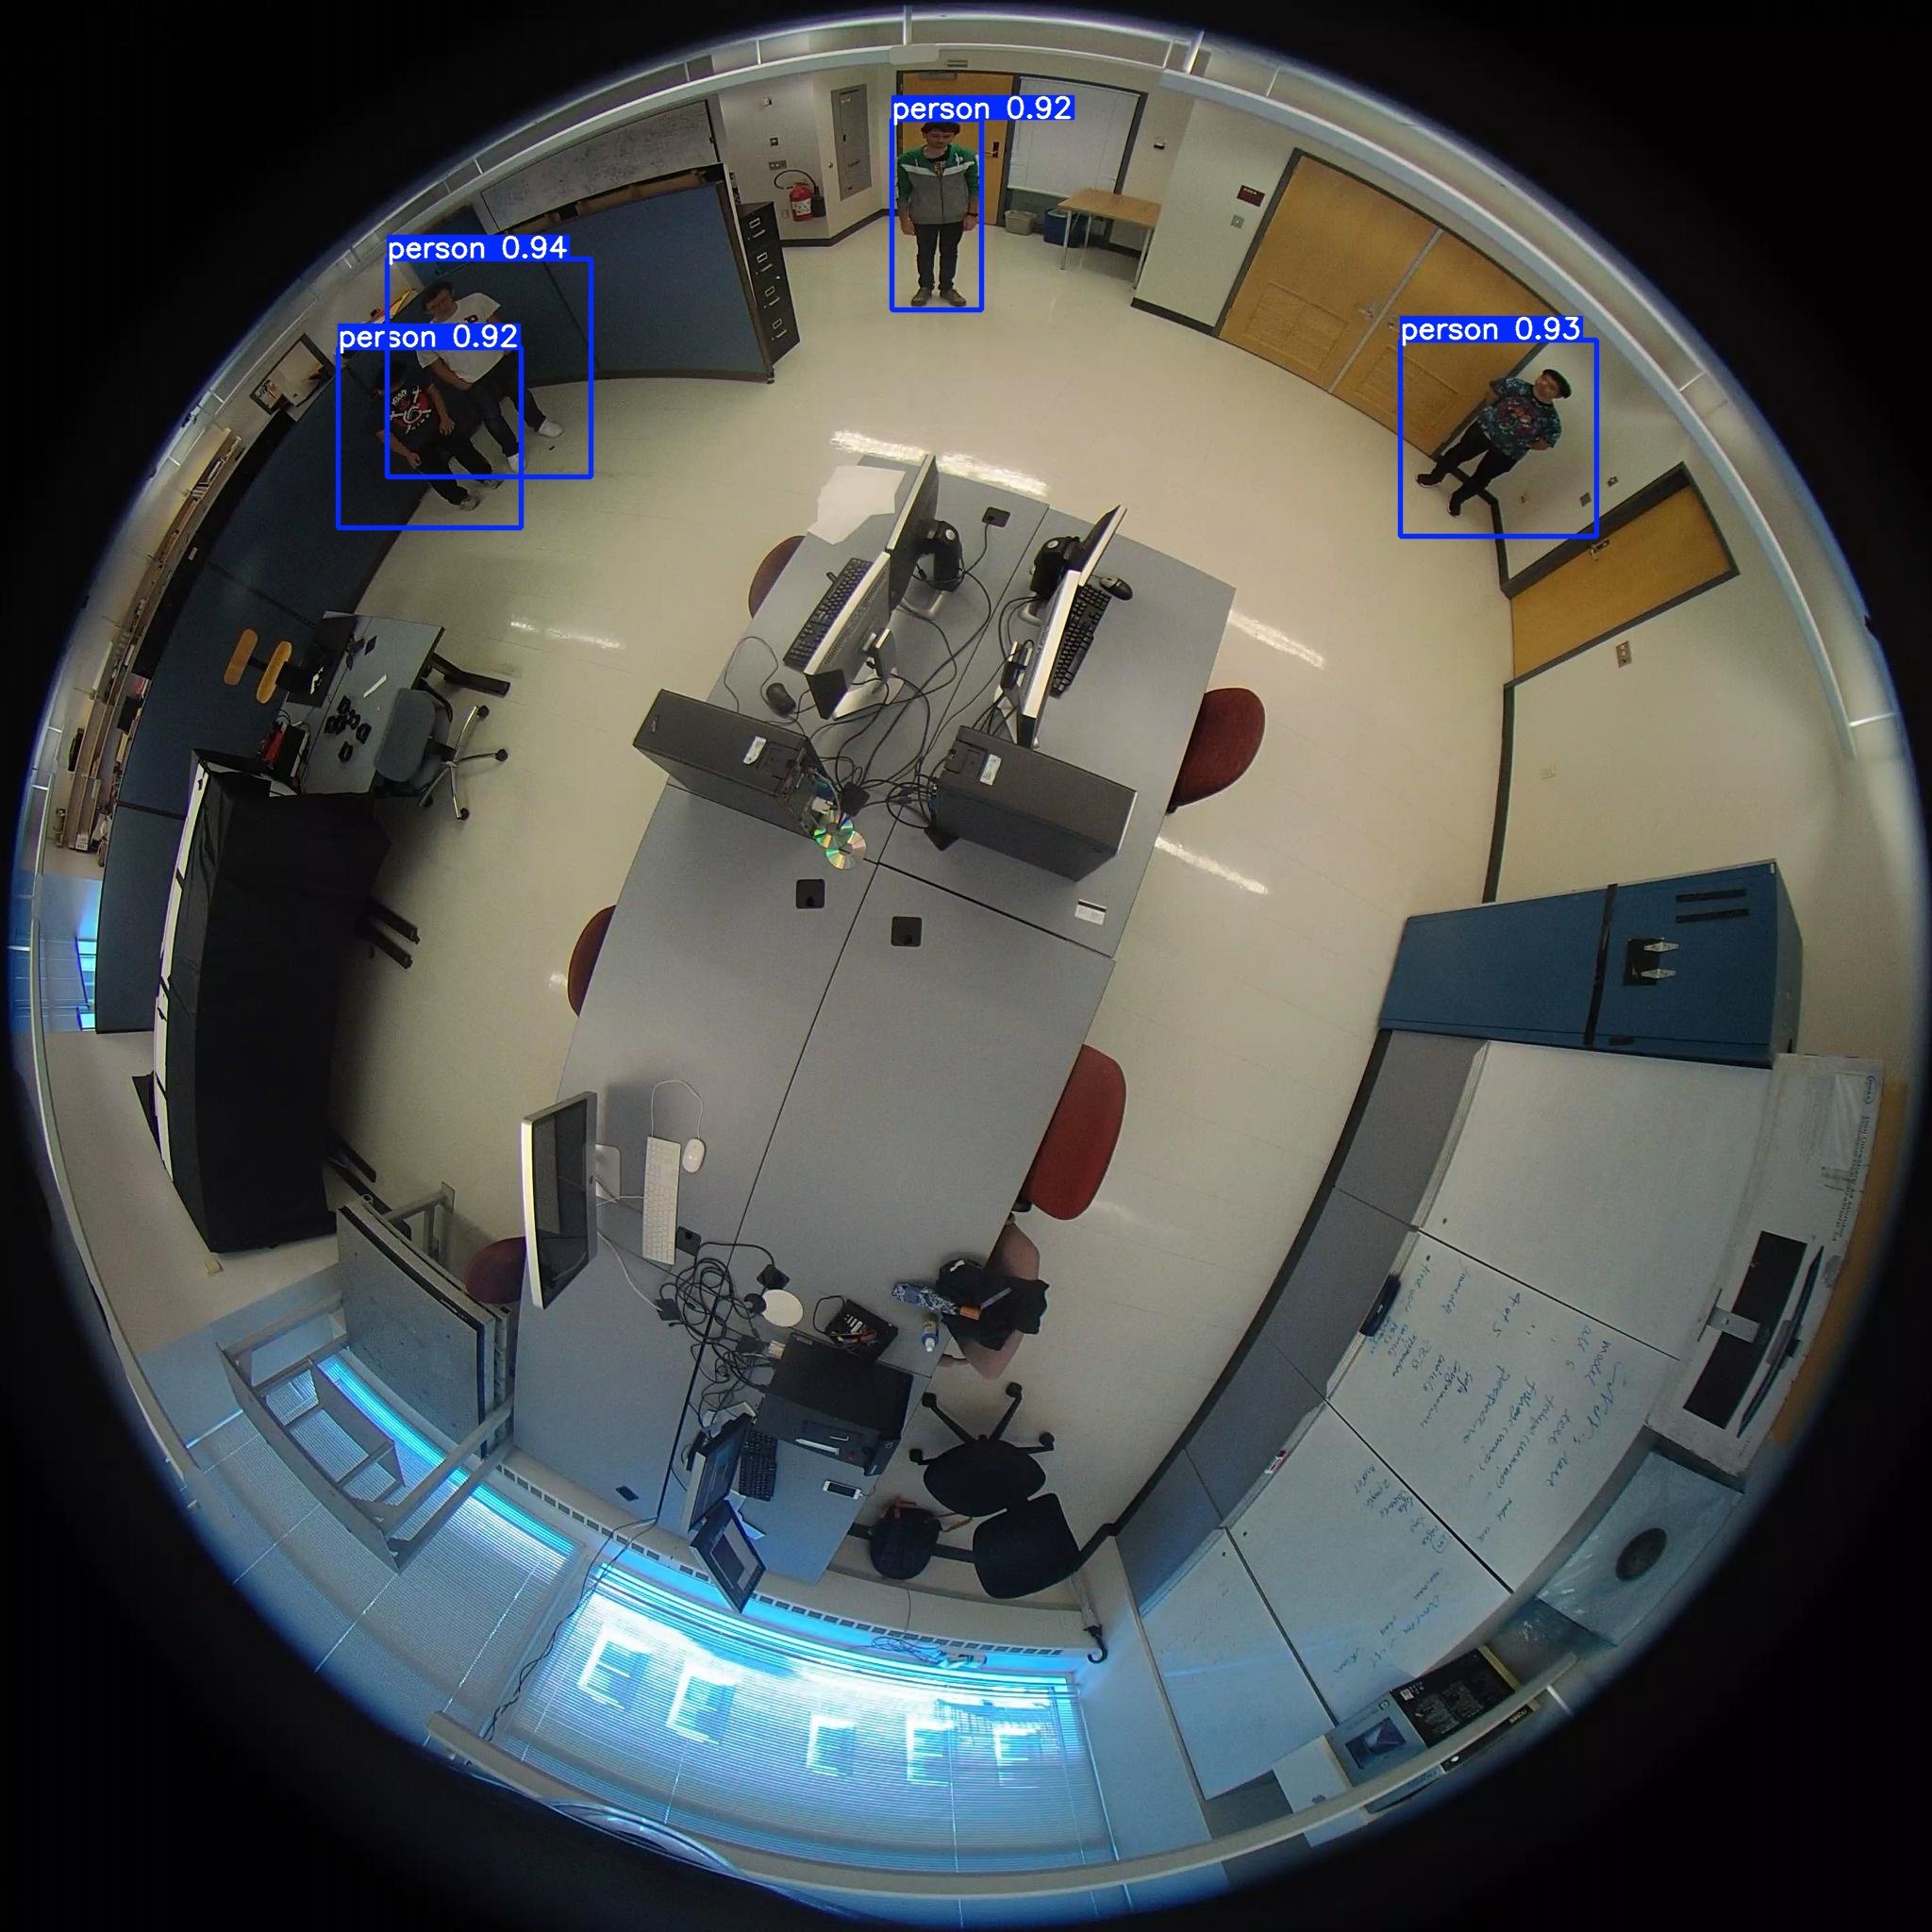

In [14]:
from IPython.display import Image, display
import glob

result_images = glob.glob('runs/detect/test_results/*.jpg')
for img_path in result_images[:5]:  # show first 5
    display(Image(filename=img_path))
